# LABORATORY SESSION - WEEK 12

## Understanding The Articles 

- What types of trolls are there in the database?
    - normal american citizens (comments on real time events)
    - local news outlets (violence)
    - local political party (republican)
- How to tell them apart?
    - community detection algorithm
- What do trolls do?
    - rigth wing (positive tweets)
    - left wing (negative tweets)
    - black lives matter community
- What hashtags they used?
    - ashtags

In [42]:
# import 
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from datetime import datetime
import random
import matplotlib.patches as mpatches

### Problem 1 

Import tweeter data. Draw networks illustrating the relationships inside them. 

### Solution 

In [32]:
# Data file paths
tweets_dir = "data/tweets.csv"
users_dir = "data/users.csv"

# Load datasets using pandas
tweets_df = pd.read_csv(tweets_dir)
users_df = pd.read_csv(users_dir)

# Compute and display the number of rows and columns for each dataset
print("\nTweets Dataset Dimensions:")
print(f"Rows: {tweets_df.shape[0]}, Columns: {tweets_df.shape[1]}")

print("\nUsers Dataset Dimensions:")
print(f"Rows: {users_df.shape[0]}, Columns: {users_df.shape[1]}")

# Display column names for clarity
print("\nTweets Dataset Columns:")
print(tweets_df.columns)

print("\nUsers Dataset Columns:")
print(users_df.columns)

# Display attribute by attribute for an example row from Tweets dataset
print("\nExample Row from Tweets Dataset (Attribute by Attribute):")
example_tweet = tweets_df.iloc[0]
for column, value in example_tweet.items():
    print(f"{column}: {value}")

# Display attribute by attribute for an example row from Users dataset
print("\nExample Row from Users Dataset (Attribute by Attribute):")
example_user = users_df.iloc[0]
for column, value in example_user.items():
    print(f"{column}: {value}")



Tweets Dataset Dimensions:
Rows: 203451, Columns: 16

Users Dataset Dimensions:
Rows: 453, Columns: 14

Tweets Dataset Columns:
Index(['user_id', 'user_key', 'created_at', 'created_str', 'retweet_count',
       'retweeted', 'favorite_count', 'text', 'tweet_id', 'source', 'hashtags',
       'expanded_urls', 'posted', 'mentions', 'retweeted_status_id',
       'in_reply_to_status_id'],
      dtype='object')

Users Dataset Columns:
Index(['id', 'location', 'name', 'followers_count', 'statuses_count',
       'time_zone', 'verified', 'lang', 'screen_name', 'description',
       'created_at', 'favourites_count', 'friends_count', 'listed_count'],
      dtype='object')

Example Row from Tweets Dataset (Attribute by Attribute):
user_id: 2532611755.0
user_key: kathiemrr
created_at: 1488207240000.0
created_str: 2017-02-27 14:54:00
retweet_count: nan
retweeted: nan
favorite_count: nan
text: #ThingsDoneByMistake kissing auntie in the lips
tweet_id: 8.362278918976512e+17
source: nan
hashtags: ["Thin

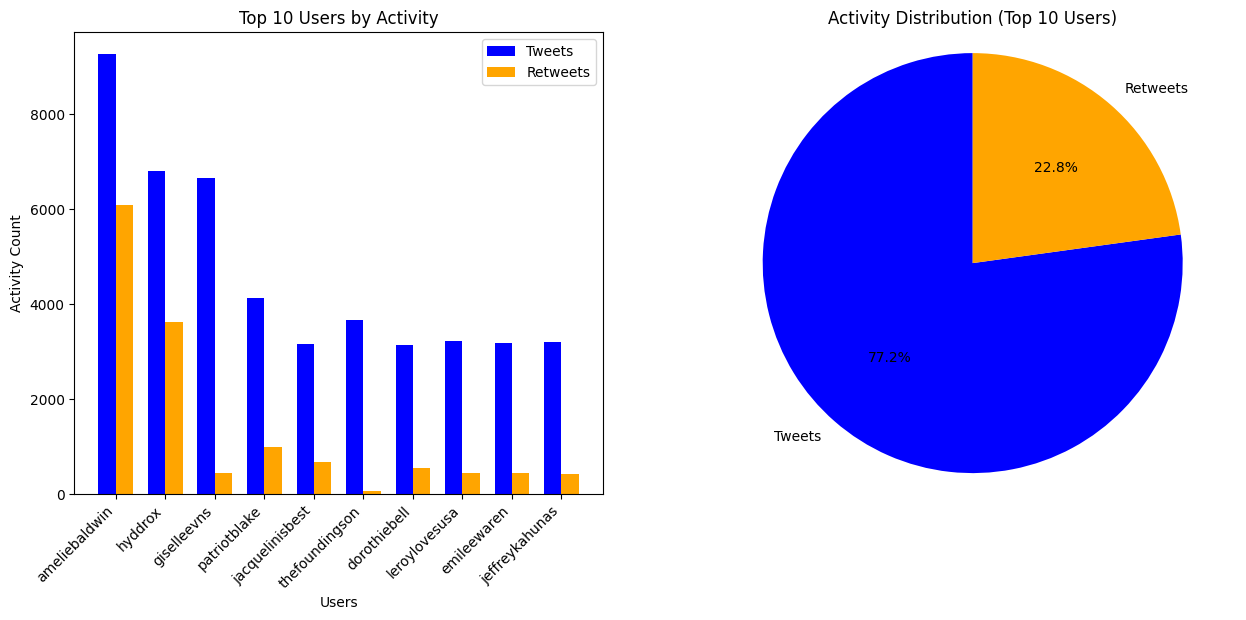

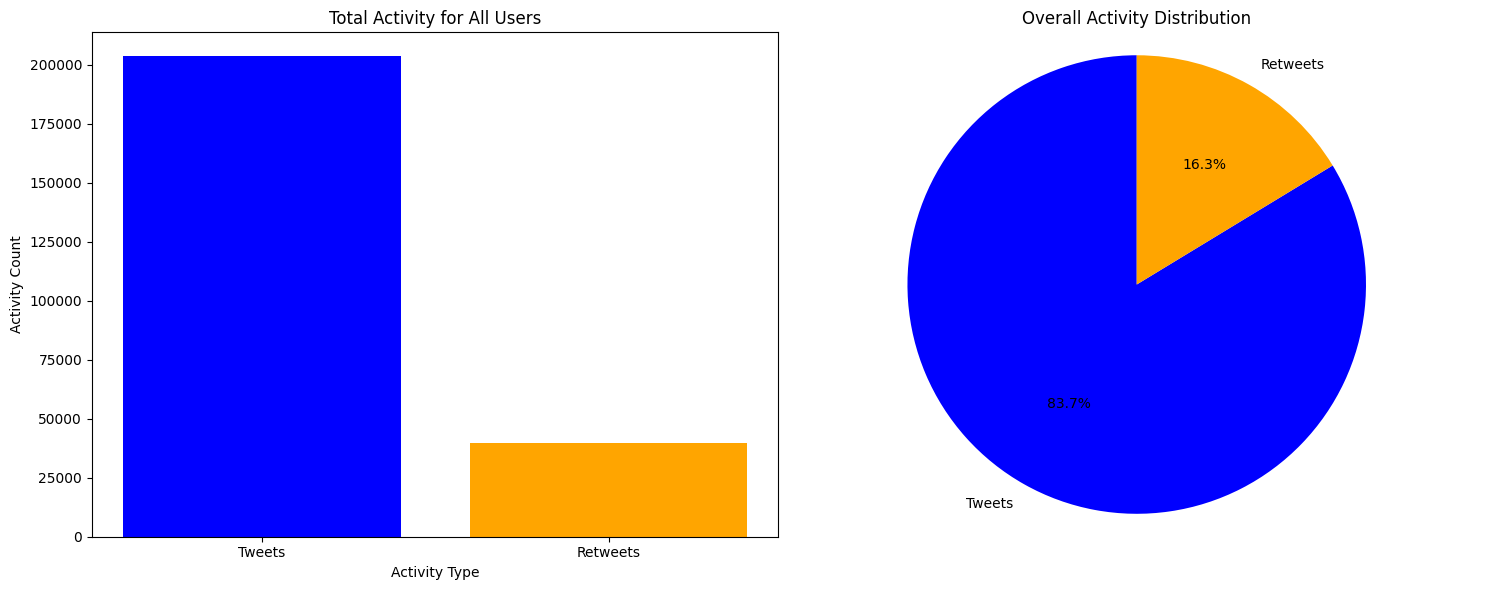

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Group data by user and compute activity metrics
def compute_user_activity(tweets_df):
    # Initialize a dictionary to store activity
    user_activity = tweets_df.groupby('user_key').agg(
        tweets=('user_key', 'size'),  # Count total tweets
        retweets=('retweeted_status_id', lambda x: x.notna().sum())  # Count retweets
    ).reset_index()
    return user_activity

# Load data
tweets_dir = "data/tweets.csv"
tweets_df = pd.read_csv(tweets_dir)

# Compute activity
user_activity = compute_user_activity(tweets_df)

# Sort by total activity for plotting (Top 10 Users)
user_activity['total_activity'] = user_activity['tweets'] + user_activity['retweets']
top_users = user_activity.sort_values(by='total_activity', ascending=False).head(10)

# Analysis on the entire user base (all users)
total_tweets = user_activity['tweets'].sum()
total_retweets = user_activity['retweets'].sum()

# Plot activity
def plot_user_activity(top_users, user_activity):
    # Prepare for plotting
    x = np.arange(len(top_users))
    width = 0.35  # Bar width
    
    # Create the bar chart for tweets and retweets (Top 10 users)
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Bar chart for Tweets and Retweets (Top 10 Users)
    ax[0].bar(x - width/2, top_users['tweets'], width, label='Tweets', color='blue')
    ax[0].bar(x + width/2, top_users['retweets'], width, label='Retweets', color='orange')

    ax[0].set_xticks(x)
    ax[0].set_xticklabels(top_users['user_key'], rotation=45, ha='right')
    ax[0].set_xlabel('Users')
    ax[0].set_ylabel('Activity Count')
    ax[0].set_title('Top 10 Users by Activity')
    ax[0].legend()

    # Pie chart for distribution of tweet and retweet activities for top users
    activities = [top_users['tweets'].sum(), top_users['retweets'].sum()]
    labels = ['Tweets', 'Retweets']
    colors = ['blue', 'orange']
    
    ax[1].pie(activities, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax[1].set_title('Activity Distribution (Top 10 Users)')

    # Plotting total activity for all users (bar chart and pie chart)
    fig2, ax2 = plt.subplots(1, 2, figsize=(15, 6))

    # Bar chart for total tweets and retweets (All Users)
    ax2[0].bar(['Tweets', 'Retweets'], [total_tweets, total_retweets], color=['blue', 'orange'])
    ax2[0].set_xlabel('Activity Type')
    ax2[0].set_ylabel('Activity Count')
    ax2[0].set_title('Total Activity for All Users')

    # Pie chart for the entire user base distribution
    total_activities = [total_tweets, total_retweets]
    labels = ['Tweets', 'Retweets']
    colors = ['blue', 'orange']
    
    ax2[1].pie(total_activities, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax2[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax2[1].set_title('Overall Activity Distribution')

    plt.tight_layout()
    plt.show()

# Plot the activity for the top users and the entire user base
plot_user_activity(top_users, user_activity)


In [59]:
def create_twitter_network(users_df: pd.DataFrame, tweets_df: pd.DataFrame) -> nx.Graph:
    """
    Creates an undirected graph representing a Twitter network based on user interactions.
    
    Parameters:
        users_df (pd.DataFrame): DataFrame with user data containing ['id', 'name', 'location']
        tweets_df (pd.DataFrame): DataFrame with tweet data containing 
                                ['user_id', 'mentions', 'retweeted_status_id', 'tweet_id', 'text']
    
    Returns:
        nx.Graph: Undirected graph where nodes are users and edges represent interactions
    """
    # Initialize graph
    G = nx.Graph()
    
    def add_users_from_dataframe():
        """Add users from users_df as nodes with attributes."""
        for _, user in users_df.iterrows():
            user_id = user['id']
            if user_id is not None:
                G.add_node(
                    user_id,
                    name=str(user.get('name', '')),
                    location=str(user.get('location', '')),
                    type='user'
                )
    
    def add_users_from_tweets():
        """Add users found in tweets but not in users_df."""
        tweet_users = pd.unique(tweets_df['user_id'].dropna())
        for user_id in tweet_users:
            if user_id is not None and not G.has_node(user_id):
                print("adding user")
                G.add_node(
                    user_id,
                    name=f"User_{user_id}",
                    location="Unknown",
                    type='user'
                )
    
    def add_interaction_edges():
        """Add edges based on mentions and retweets."""
        for _, tweet in tweets_df.iterrows():
            source_id = tweet['user_id']
            if source_id is None:
                continue
                
            # Handle mentions
            if isinstance(tweet['mentions'], list):
                for mentioned in tweet['mentions']:
                    target_id = mentioned
                    if target_id is not None and source_id != target_id:
                        # Update edge weight and store interaction details
                        if G.has_edge(source_id, target_id):
                            G[source_id][target_id]['weight'] += 1
                            G[source_id][target_id]['tweets'].append(tweet['tweet_id'])
                        else:
                            G.add_edge(
                                source_id,
                                target_id,
                                weight=1,
                                type='mention',
                                tweets=[tweet['tweet_id']]
                            )
            
            # Handle retweets
            if pd.notnull(tweet['retweeted_status_id']):
                # Find original tweet's user
                original_tweet = tweets_df[tweets_df['tweet_id'] == tweet['retweeted_status_id']]
                if not original_tweet.empty:
                    target_id = original_tweet.iloc[0]['user_id']
                    if target_id is not None and source_id != target_id:
                        # Update edge weight and store interaction details
                        if G.has_edge(source_id, target_id):
                            G[source_id][target_id]['weight'] += 1
                            G[source_id][target_id]['tweets'].append(tweet['tweet_id'])
                        else:
                            G.add_edge(
                                source_id,
                                target_id,
                                weight=1,
                                type='retweet',
                                tweets=[tweet['tweet_id']]
                            )
    
    # Build network
    add_users_from_dataframe()
    add_users_from_tweets()
    add_interaction_edges()
    
    # Remove isolated nodes (users with no interactions)
    G.remove_nodes_from(list(nx.isolates(G)))
    
    return G

def get_network_stats(G: nx.Graph) -> dict:
    """
    Calculate basic network statistics.
    
    Parameters:
        G (nx.Graph): NetworkX graph object
    
    Returns:
        dict: Dictionary containing network statistics
    """
    return {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
        'num_components': nx.number_connected_components(G),
        'largest_component_size': len(max(nx.connected_components(G), key=len)),
        'avg_clustering': nx.average_clustering(G),
        'mention_edges': sum(1 for _, _, d in G.edges(data=True) if d.get('type') == 'mention'),
        'retweet_edges': sum(1 for _, _, d in G.edges(data=True) if d.get('type') == 'retweet')
    }

# Create network
G = create_twitter_network(users_df, tweets_df)

# Get network statistics
stats = get_network_stats(G)
print("\nNetwork Statistics:")
for key, value in stats.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")

"""
# Example of filtering by interaction type
mention_network = nx.Graph((u, v, d) for u, v, d in G.edges(data=True) 
                         if d['type'] == 'mention')
retweet_network = nx.Graph((u, v, d) for u, v, d in G.edges(data=True) 
                         if d['type'] == 'retweet')

# Get network statistics
stats = get_network_stats(mention_network)
print("\nMention Network Statistics:")
for key, value in stats.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")

# Get network statistics
stats = get_network_stats(retweet_network)
print("\nRetweet Network Statistics:")
for key, value in stats.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")
"""


Network Statistics:
num_nodes: 214
num_edges: 612
density: 0.03
avg_degree: 5.72
num_components: 10
largest_component_size: 195
avg_clustering: 0.21
mention_edges: 0
retweet_edges: 612


'\n# Example of filtering by interaction type\nmention_network = nx.Graph((u, v, d) for u, v, d in G.edges(data=True) \n                         if d[\'type\'] == \'mention\')\nretweet_network = nx.Graph((u, v, d) for u, v, d in G.edges(data=True) \n                         if d[\'type\'] == \'retweet\')\n\n# Get network statistics\nstats = get_network_stats(mention_network)\nprint("\nMention Network Statistics:")\nfor key, value in stats.items():\n    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")\n\n# Get network statistics\nstats = get_network_stats(retweet_network)\nprint("\nRetweet Network Statistics:")\nfor key, value in stats.items():\n    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")\n'

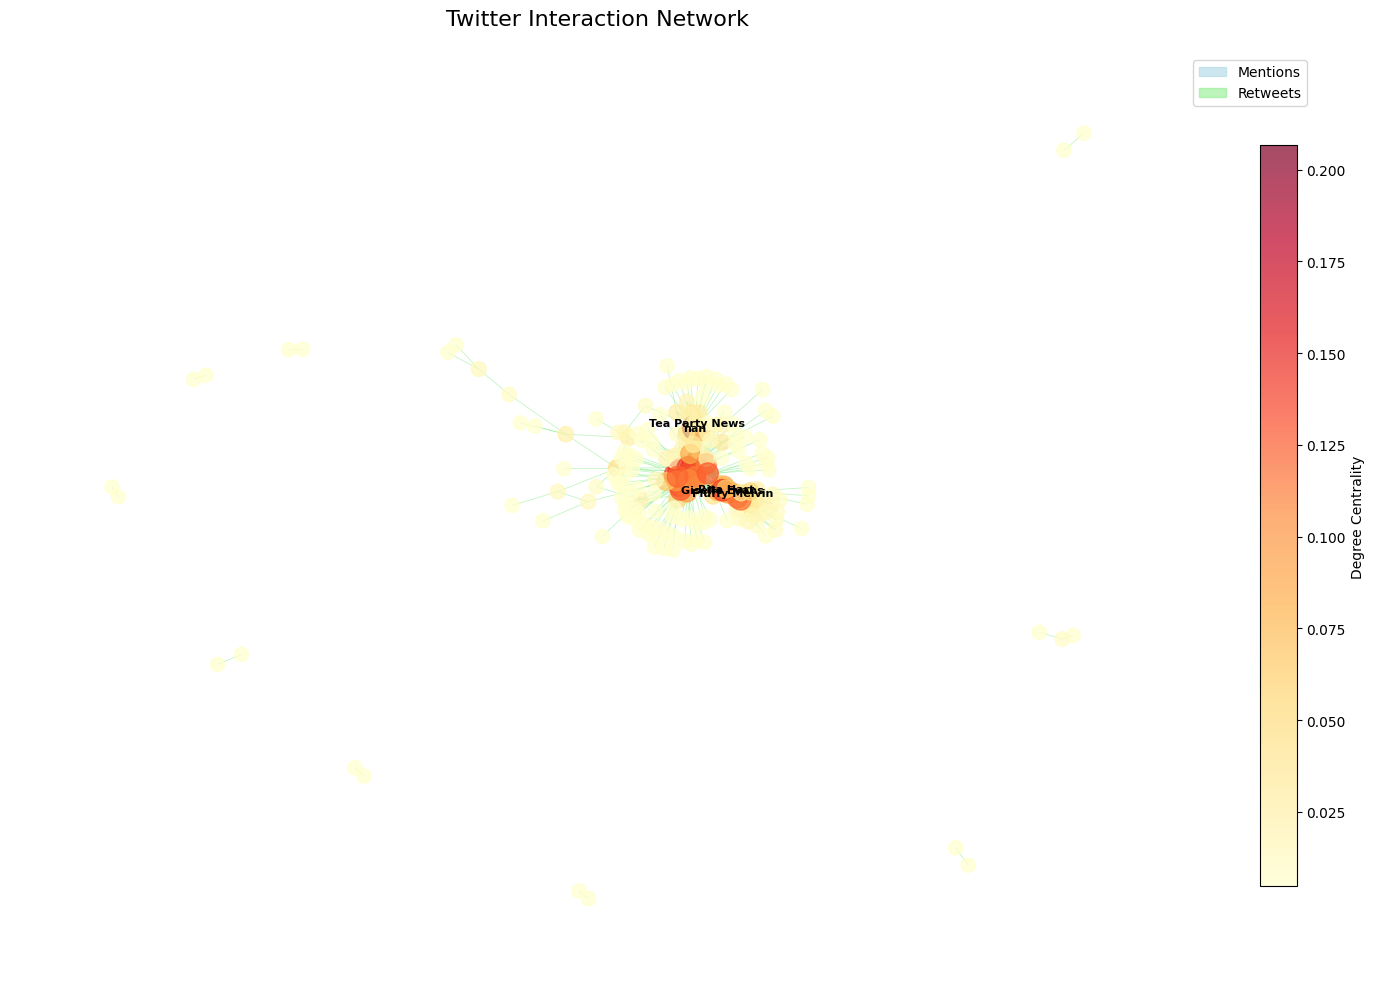

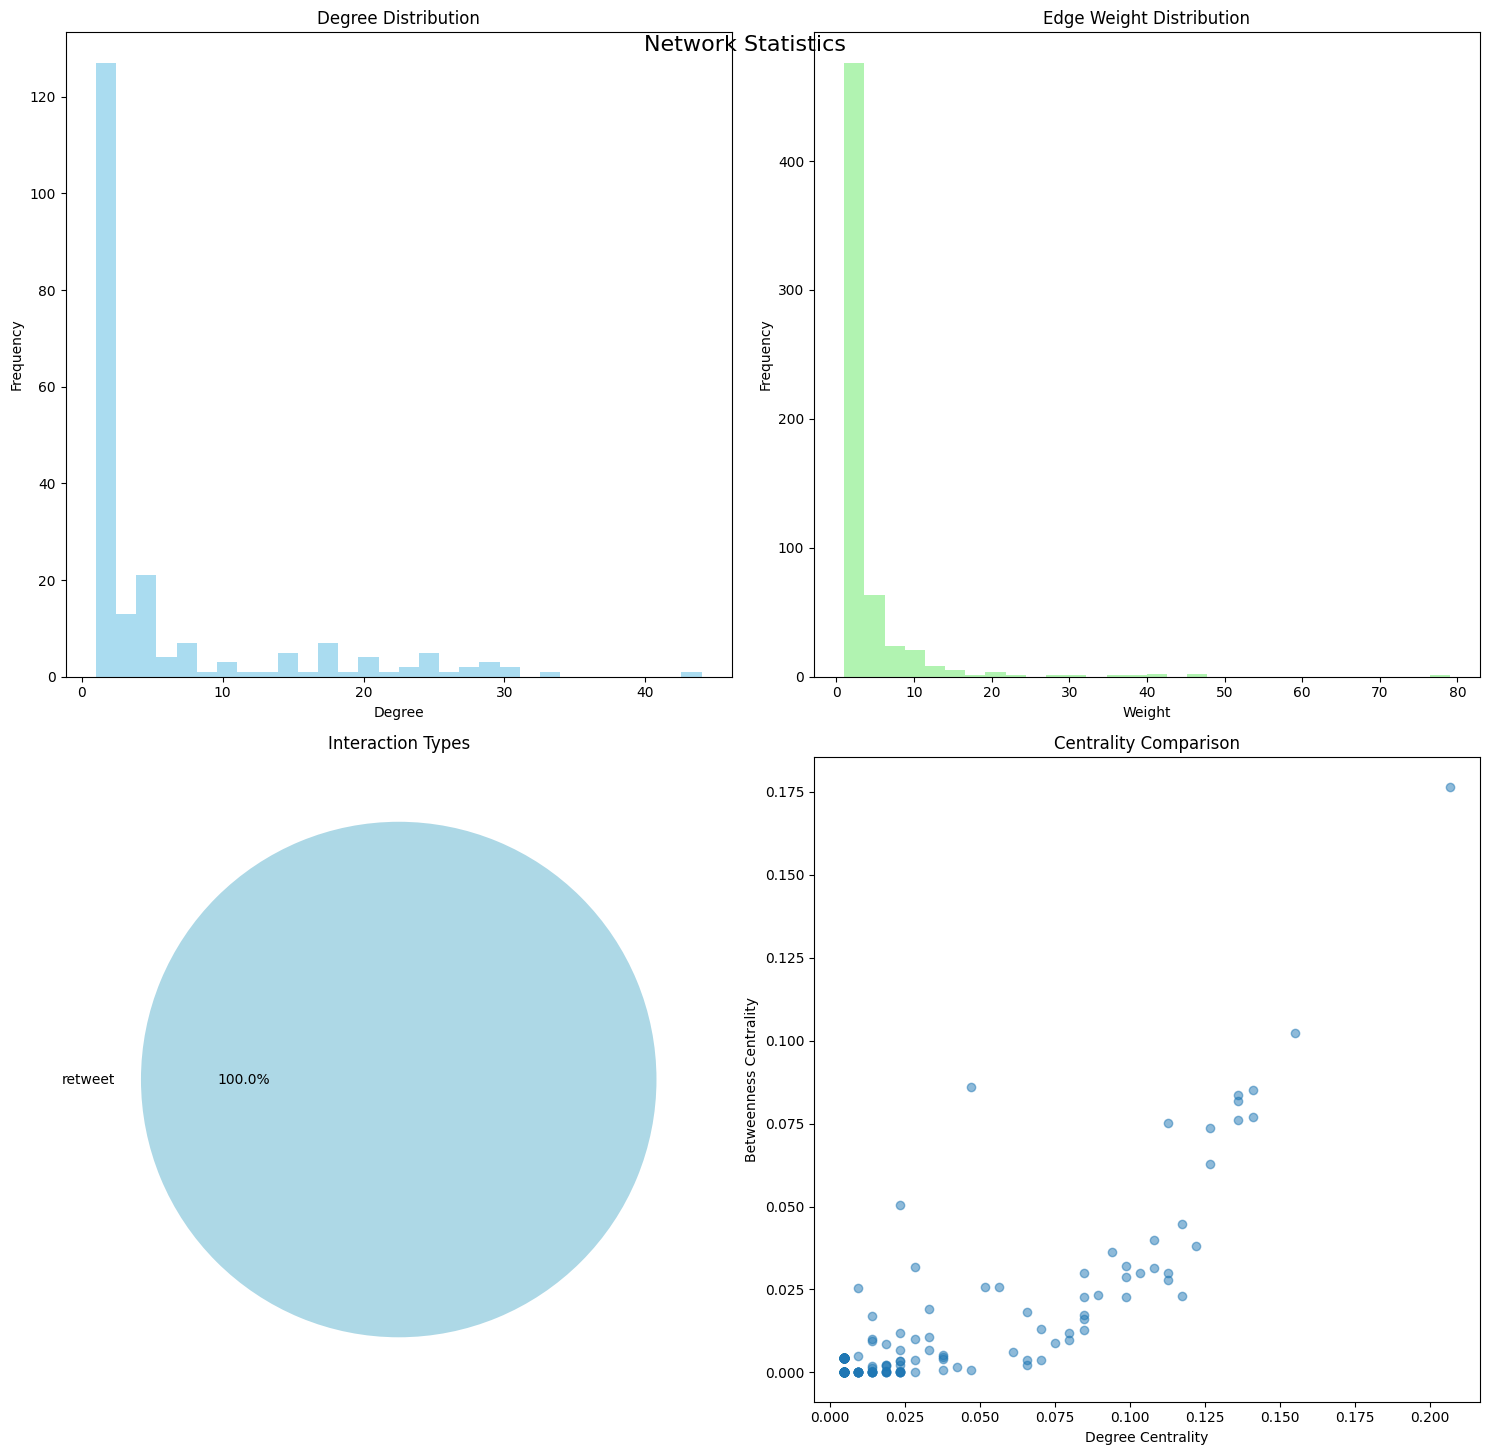

In [60]:
def visualize_network(G, title="Twitter Interaction Network", figsize=(15, 10)):
    """
    Creates an enhanced visualization of the Twitter interaction network.
    
    Parameters:
        G (nx.Graph): NetworkX graph of Twitter interactions
        title (str): Title for the visualization
        figsize (tuple): Figure size in inches
    """
    # Create figure
    plt.figure(figsize=figsize)
    plt.axis('off')
    
    # Calculate node sizes based on degree centrality
    degree_cent = nx.degree_centrality(G)
    node_sizes = [1000 * degree_cent[node] + 100 for node in G.nodes()]
    
    # Calculate edge weights for thickness
    edge_weights = [G[u][v].get('weight', 1) for u, v in G.edges()]
    max_weight = max(edge_weights)
    normalized_weights = [0.5 + 2.0 * (w / max_weight) for w in edge_weights]
    
    # Set up layout
    pos = nx.spring_layout(G, k=1/np.sqrt(len(G.nodes())), seed=42)
    
    # Separate edges by type
    mention_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'mention']
    retweet_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'retweet']
    
    # Draw edges
    nx.draw_networkx_edges(G, pos,
                          edgelist=mention_edges,
                          edge_color='lightblue',
                          alpha=0.6,
                          width=[normalized_weights[i] for i, (u, v) in enumerate(G.edges()) 
                                if (u, v) in mention_edges or (v, u) in mention_edges])
    
    nx.draw_networkx_edges(G, pos,
                          edgelist=retweet_edges,
                          edge_color='lightgreen',
                          alpha=0.6,
                          width=[normalized_weights[i] for i, (u, v) in enumerate(G.edges())
                                if (u, v) in retweet_edges or (v, u) in retweet_edges])
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, pos,
                                 node_size=node_sizes,
                                 node_color=list(degree_cent.values()),
                                 cmap=plt.cm.YlOrRd,
                                 alpha=0.7)
    
    # Add colorbar for node centrality
    plt.colorbar(nodes, label='Degree Centrality', shrink=0.8)
    
    # Add labels for top nodes
    # Calculate node importance based on both degree and edge weights
    node_importance = {}
    for node in G.nodes():
        degree = G.degree(node, weight='weight')
        node_importance[node] = degree
    
    top_nodes = sorted(node_importance.items(), key=lambda x: x[1], reverse=True)[:5]
    labels = {node: G.nodes[node].get('name', f'User_{node}') 
             for node, _ in top_nodes}
    
    nx.draw_networkx_labels(G, pos,
                          labels=labels,
                          font_size=8,
                          font_weight='bold')
    
    # Add legend
    legend_elements = [
        mpatches.Patch(color='lightblue', alpha=0.6, label='Mentions'),
        mpatches.Patch(color='lightgreen', alpha=0.6, label='Retweets'),
    ]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    
    # Add title and adjust layout
    plt.title(title, pad=20, size=16)
    plt.tight_layout()
    
    return plt

def plot_network_statistics(G):
    """
    Creates a subplot of various network statistics visualizations.
    
    Parameters:
        G (nx.Graph): NetworkX graph of Twitter interactions
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle('Network Statistics', fontsize=16, y=0.95)
    
    # Degree distribution
    degrees = [d for n, d in G.degree()]
    axes[0, 0].hist(degrees, bins=30, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Degree Distribution')
    axes[0, 0].set_xlabel('Degree')
    axes[0, 0].set_ylabel('Frequency')
    
    # Edge weight distribution
    weights = [d['weight'] for u, v, d in G.edges(data=True)]
    axes[0, 1].hist(weights, bins=30, alpha=0.7, color='lightgreen')
    axes[0, 1].set_title('Edge Weight Distribution')
    axes[0, 1].set_xlabel('Weight')
    axes[0, 1].set_ylabel('Frequency')
    
    # Interaction types
    interaction_types = [d['type'] for u, v, d in G.edges(data=True)]
    type_counts = pd.Series(interaction_types).value_counts()
    axes[1, 0].pie(type_counts, labels=type_counts.index, autopct='%1.1f%%',
                   colors=['lightblue', 'lightgreen'])
    axes[1, 0].set_title('Interaction Types')
    
    # Node centrality comparison
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    axes[1, 1].scatter(list(degree_cent.values()), 
                      list(betweenness_cent.values()),
                      alpha=0.5)
    axes[1, 1].set_xlabel('Degree Centrality')
    axes[1, 1].set_ylabel('Betweenness Centrality')
    axes[1, 1].set_title('Centrality Comparison')
    
    plt.tight_layout()
    return plt

# Example usage:

# Create and visualize the network
G = create_twitter_network(users_df, tweets_df)

# Basic network visualization
visualize_network(G)
plt.show()

# Detailed statistics visualization
plot_network_statistics(G)
plt.show()

### Problem 2 

Prepare an infographics/presentation/report containing the most interesting conclusions from the analysis of the results of the previous task.

### Solution 